In [29]:
from pint.logging import setup as setup_log

from enterprise.pulsar import Pulsar
from enterprise.signals.signal_base import PTA
from enterprise.signals.white_signals import MeasurementNoise
from enterprise.signals.gp_signals import MarginalizingTimingModel
from enterprise_extensions.blocks import red_noise_block, dm_noise_block

from PTMCMCSampler.PTMCMCSampler import PTSampler

import numpy as np
import corner
import matplotlib.pyplot as plt

In [30]:
setup_log(level="WARNING")

2

In [49]:
psr = Pulsar("sim5.fit.par", "sim5.tim", timing_package="pint")

In [50]:
tm = MarginalizingTimingModel()
wn = MeasurementNoise(efac=1)
rn = red_noise_block(components=30)
dmn = dm_noise_block(components=30)

In [51]:
signal = tm + wn + dmn + rn

In [52]:
pta = PTA([signal(psr)])

In [53]:
pta.param_names

['SIM3_dm_gp_gamma',
 'SIM3_dm_gp_log10_A',
 'SIM3_red_noise_gamma',
 'SIM3_red_noise_log10_A']

In [54]:
ndim = len(pta.param_names)
x0 = np.array(
    [4, -13.5, 3.5, -13.0]
    # [p.sample() for p in pta.params]
)
cov = np.diag(np.ones(ndim)) * 1e-4
outdir = "chains/"
Niter = 200000

In [55]:
sampler = PTSampler(
    ndim,
    pta.get_lnlikelihood,
    pta.get_lnprior,
    cov,
    outDir=outdir,
)

In [56]:
sampler.sample(
    x0,
    Niter,
)

Finished 0.00 percent in 0.000582 s Acceptance rate = 0

Finished 5.00 percent in 13.296082 s Acceptance rate = 0.584814Adding DE jump with weight 20
Finished 100.00 percent in 219.936900 s Acceptance rate = 0.48298
Run Complete


WARNING  (pint.logging                  ): /home/abhimanyu/miniconda3/envs/pint-noise/lib/python3.9/site-packages/enterprise/signals/parameter.py:62 RuntimeWarning: divide by zero encountered in log


In [57]:
chain = np.genfromtxt(f"{outdir}/chain_1.txt")
burn = chain.shape[0]//5
burned_chain = chain[burn:, :-4]
# burned_chain[:, 1] = 10**burned_chain[:, 1] * 1e6

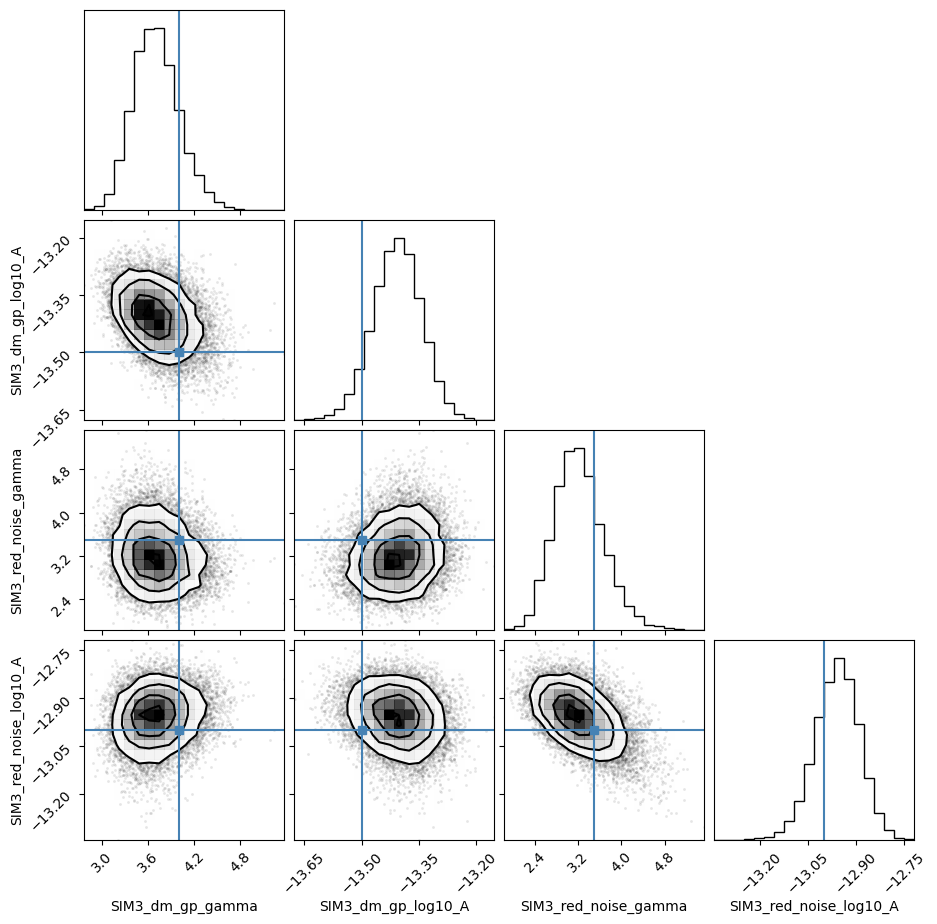

In [58]:
fig = corner.corner(
    burned_chain, 
    labels=pta.param_names, 
    truths=[4, -13.5, 3.5, -13.0],
)
